### Objective<a href="#Objective" class="anchor-link">¶</a>

Prepare the dataset for analysis, using methods learnt and researched
independently, including but not limited to Missing Value Imputation,
Outlier Detection etc.

Find out your observations on different variables using descriptive
statistics, Visualization etc. Report if there is any pattern present in
the data.

Perform clustering analysis on the data set using different models.
Compare all models using various performance metrics. Provide the
inferences to your findings.

In \[1\]:

    #Import Libraries and Load Dataset
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings
    warnings.filterwarnings("ignore")

    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.impute import KNNImputer
    from sklearn.manifold import TSNE
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, mean_squared_error, r2_score, mean_absolute_error, classification_report
    from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
    from sklearn.ensemble import IsolationForest, RandomForestRegressor, RandomForestClassifier
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import NearestNeighbors
    from scipy.stats import zscore, chi2_contingency
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from datetime import datetime

    sns.set(style="whitegrid")

    # Load data
    df = pd.read_csv(r"E:\Group B\Live.csv")
    print("Initial shape of dataset:", df.shape)
    print("\nDataset Info:")
    print(df.info())

    Initial shape of dataset: (7050, 16)

    Dataset Info:
    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 7050 entries, 0 to 7049
    Data columns (total 16 columns):
     #   Column            Non-Null Count  Dtype  
    ---  ------            --------------  -----  
     0   status_id         7050 non-null   object 
     1   status_type       7050 non-null   object 
     2   status_published  7050 non-null   object 
     3   num_reactions     7050 non-null   int64  
     4   num_comments      7050 non-null   int64  
     5   num_shares        7050 non-null   int64  
     6   num_likes         7050 non-null   int64  
     7   num_loves         7050 non-null   int64  
     8   num_wows          7050 non-null   int64  
     9   num_hahas         7050 non-null   int64  
     10  num_sads          7050 non-null   int64  
     11  num_angrys        7050 non-null   int64  
     12  Column1           0 non-null      float64
     13  Column2           0 non-null      float64
     14  Column3           0 non-null      float64
     15  Column4           0 non-null      float64
    dtypes: float64(4), int64(9), object(3)
    memory usage: 881.4+ KB
    None

In \[2\]:

    #Initial Data Inspection and Cleaning
    # Check for missing values
    nulls = df.isnull().sum()
    print("Null values per column:\n", nulls)

    # Drop fully null columns
    fully_null_cols = df.columns[nulls == df.shape[0]]
    if len(fully_null_cols) > 0:
        df.drop(columns=fully_null_cols, inplace=True)
        print(f"\nDropped fully null columns: {list(fully_null_cols)}")

    # Convert datetime
    df["status_published"] = pd.to_datetime(df["status_published"], errors='coerce')

    # Extract time features
    df["hour"] = df["status_published"].dt.hour
    df["weekday"] = df["status_published"].dt.day_name()
    df["day"] = df["status_published"].dt.day
    df["month"] = df["status_published"].dt.month
    df["year"] = df["status_published"].dt.year

    print("\nFinal shape after initial cleaning:", df.shape)
    print("\nUnique values in each column:")
    print(df.nunique())

    Null values per column:
     status_id              0
    status_type            0
    status_published       0
    num_reactions          0
    num_comments           0
    num_shares             0
    num_likes              0
    num_loves              0
    num_wows               0
    num_hahas              0
    num_sads               0
    num_angrys             0
    Column1             7050
    Column2             7050
    Column3             7050
    Column4             7050
    dtype: int64

    Dropped fully null columns: ['Column1', 'Column2', 'Column3', 'Column4']

    Final shape after initial cleaning: (7050, 17)

    Unique values in each column:
    status_id           6997
    status_type            4
    status_published    6913
    num_reactions       1067
    num_comments         993
    num_shares           501
    num_likes           1044
    num_loves            229
    num_wows              65
    num_hahas             42
    num_sads              24
    num_angrys            14
    hour                  24
    weekday                7
    day                   31
    month                 12
    year                   7
    dtype: int64

In \[3\]:

    #Define engagement metrics
    metrics = ['num_reactions', 'num_comments', 'num_shares', 'num_likes',
               'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
    #Create engagement score
    df["engagement_score"] = df[["num_reactions", "num_comments", "num_shares"]].sum(axis=1)

In \[4\]:

    #Comprehensive Exploratory Data Analysis (EDA)
    # Univariate Analysis - Distributions
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    for i, col in enumerate(metrics):
        row, col_idx = divmod(i, 3)
        sns.histplot(df[col], kde=True, bins=30, ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

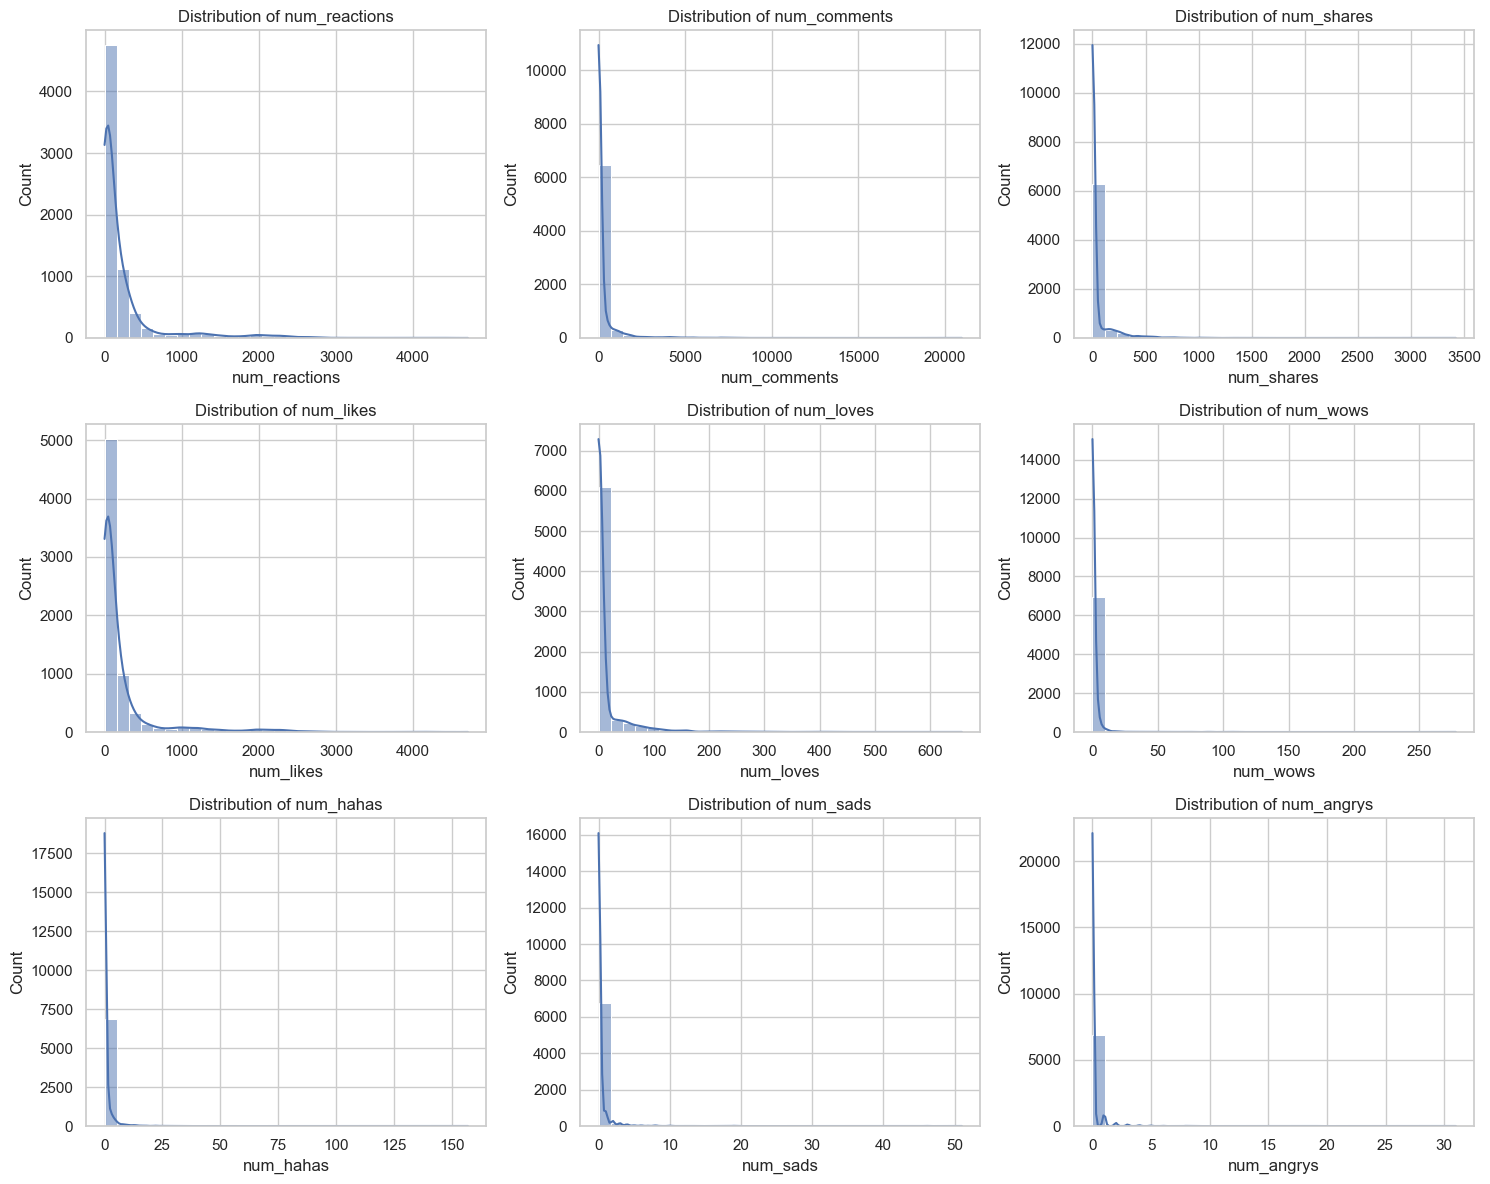

# Histograms:<a href="#Histograms:" class="anchor-link">¶</a>

Visuals: num_reactions, num_comments, num_shares, num_likes, num_loves,
num_wows, num_hahas, num_sads, num_angrys

Observations: All distributions are highly right-skewed (long tail to
the right).

Most posts receive low to moderate engagement, while a few posts receive
very high engagement.

Metrics like num_angrys, num_sads, and num_hahas have heavily
concentrated low values — often ≤ 10.

Insights: Log transformation is highly recommended before applying
distance-based algorithms or PCA.

Engagement is not normally distributed — methods assuming normality will
not perform well without preprocessing.

In \[5\]:

    # Box plots for outlier visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    for i, col in enumerate(metrics):
        row, col_idx = divmod(i, 3)
        sns.boxplot(y=df[col], ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

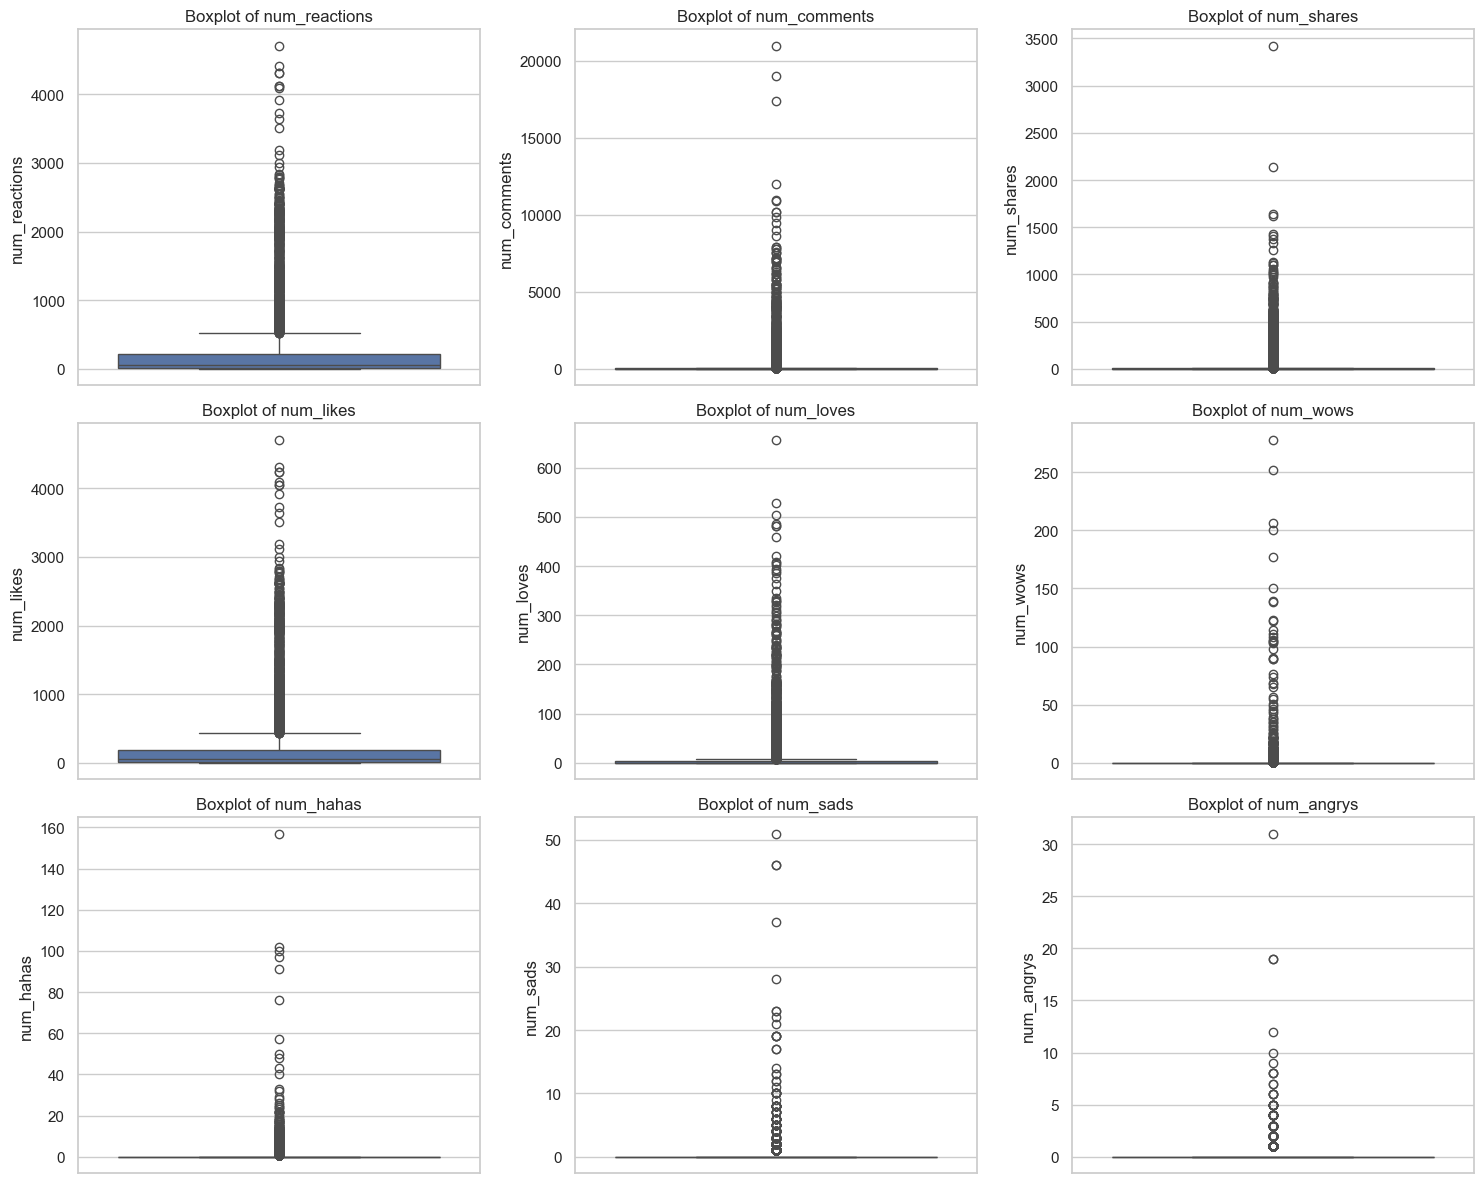

# Boxplots:<a href="#Boxplots:" class="anchor-link">¶</a>

Visuals: Boxplots for all 9 engagement metrics.

Observations: All boxplots show numerous outliers (black circles beyond
the whiskers).

Extreme outliers observed especially in:

num_comments (\> 15,000)

num_shares (\> 3,000)

num_likes and num_reactions (\> 4,000)

Smaller-scale metrics like num_angrys, num_sads, and num_hahas also show
clear outlier presence, despite smaller absolute values.

Insights: Outlier treatment is critical before clustering.

Using methods like IQR or Isolation Forest to remove/flag outliers
improves clustering accuracy.

Visualization confirms skewed nature seen in histograms.

In \[6\]:

    # Correlation Analysis
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[metrics + ['engagement_score']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt='.2f')
    plt.title("Correlation Heatmap of Engagement Metrics")
    plt.tight_layout()
    plt.show()

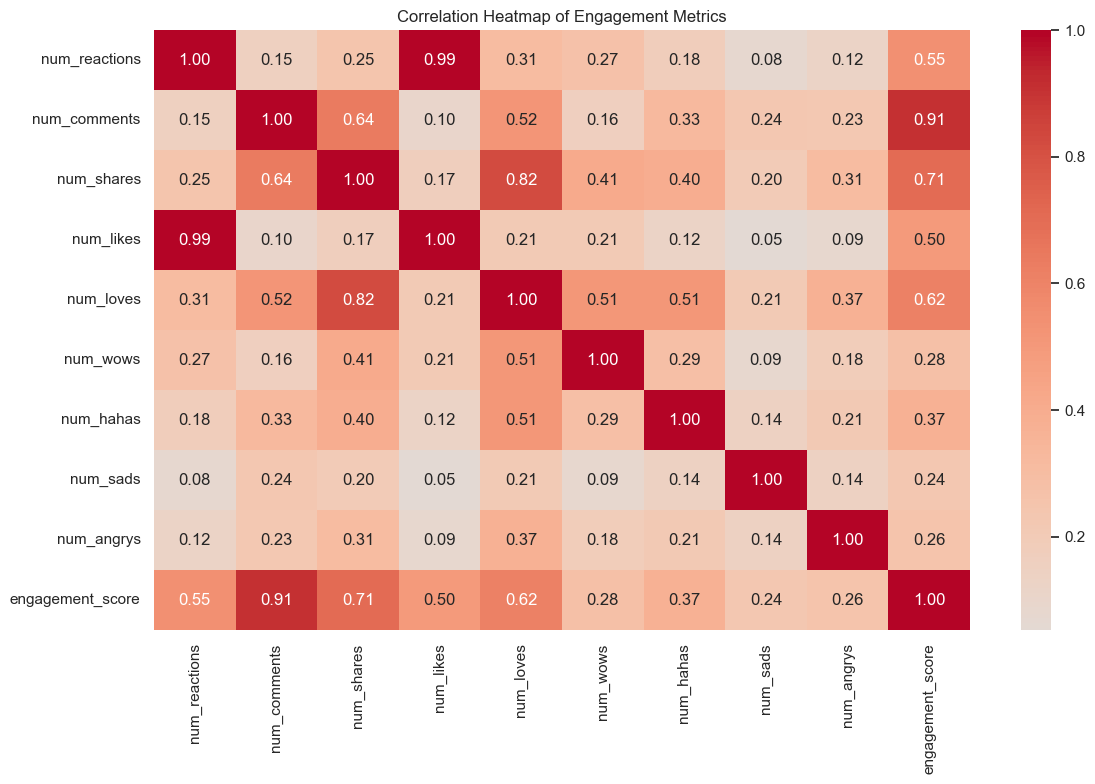

# Correlation Heatmap:<a href="#Correlation-Heatmap:" class="anchor-link">¶</a>

Visuals: Correlation of 9 engagement metrics + engagement_score.

Observations: Extremely high correlations:

num_likes ↔ num_reactions (0.99)

num_loves ↔ num_shares (0.82)

num_comments ↔ num_shares (0.64)

Moderate correlation of engagement_score with:

num_comments (0.91) — highest

num_shares (0.71)

num_loves (0.62)

Very low correlation of num_angrys, num_sads, and num_hahas with the
overall engagement score.

Insights: num_reactions is likely redundant due to high correlation with
num_likes.

Features like num_comments and num_shares are most influential in
engagement.

Consider dropping or combining highly correlated variables to reduce
redundancy.

Weakly correlated reactions (angrys, sads, hahas) add noise and may be
excluded or separately analyzed.

In \[7\]:

    # Post type distribution
    plt.figure(figsize=(8, 6))
    df['status_type'].value_counts().plot(kind='bar')
    plt.title("Distribution of Post Types")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

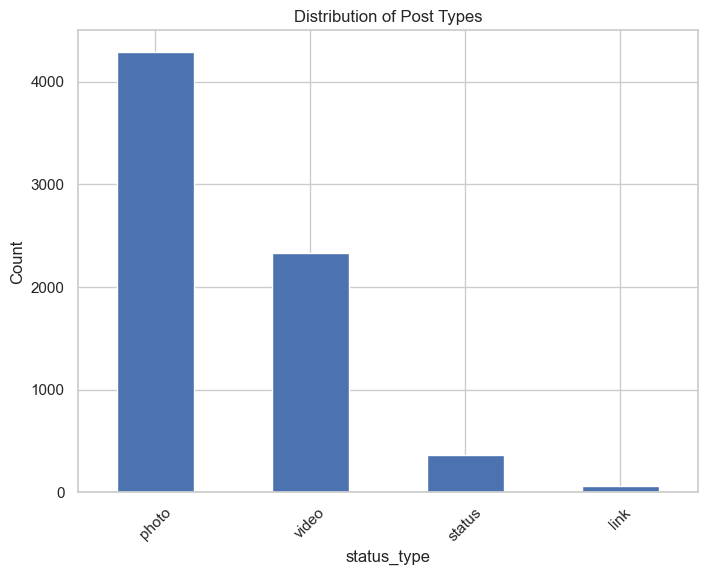

# Distribution of Post Types:<a href="#Distribution-of-Post-Types:" class="anchor-link">¶</a>

Visual: Bar plot of status_type (photo, video, status, link)

Observations: Most frequent: Photo posts (\~4,200)

Followed by: Video posts (\~2,400)

Least used: Link and Status

Insights: Majority of content is visual (photo/video) — consistent with
typical Facebook marketing strategies.

Future modeling could include dummy encoding for post type.

Investigating engagement per post type can uncover which type drives
more interaction.

In \[15\]:

    #  Part 5: Bivariate and Multivariate Analysis
    # Comments vs Shares by Post Type
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="num_comments", y="num_shares", hue="status_type", data=df, alpha=0.7)
    plt.title("Comments vs Shares by Post Type")
    plt.xlabel("Number of Comments")
    plt.ylabel("Number of Shares")
    plt.legend(title="Post Type")
    plt.show()

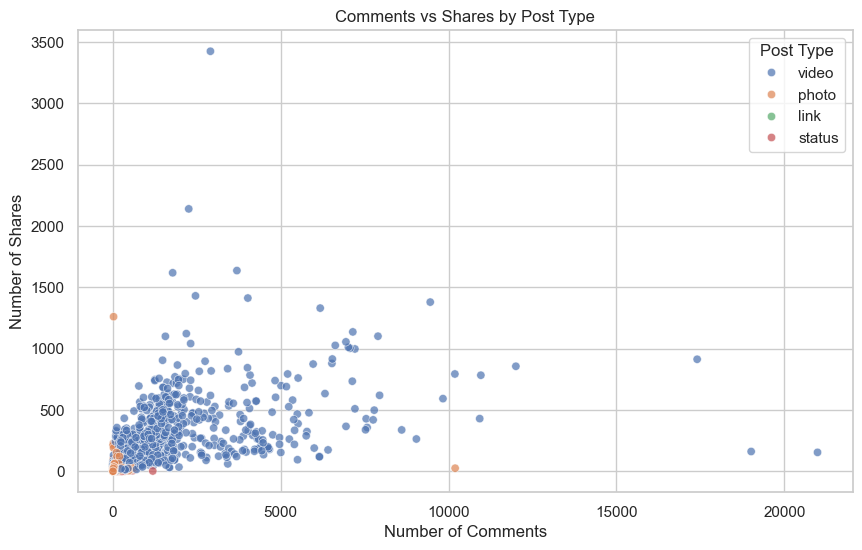

# Comments vs Shares by Post Type:<a href="#Comments-vs-Shares-by-Post-Type:" class="anchor-link">¶</a>

Chart: Scatter plot with num_comments (x) vs num_shares (y), colored by
status_type.

Observations: Most of the high-comment, high-share points are from video
posts.

Photo posts cluster near the origin (low comments, low shares).

Very few link or status posts are prominent; they remain low in both
metrics.

Insights: Video content drives higher interaction — both shares and
comments — possibly due to richer engagement.

Photo content may attract quick views/likes but less conversation or
viral sharing.

Recommend prioritizing videos for high-engagement campaigns.

In \[16\]:

    # Engagement by Post Type
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="status_type", y="engagement_score", data=df)
    plt.title("Engagement Score by Post Type")
    plt.ylabel("Engagement Score")
    plt.xticks(rotation=45)
    plt.show()

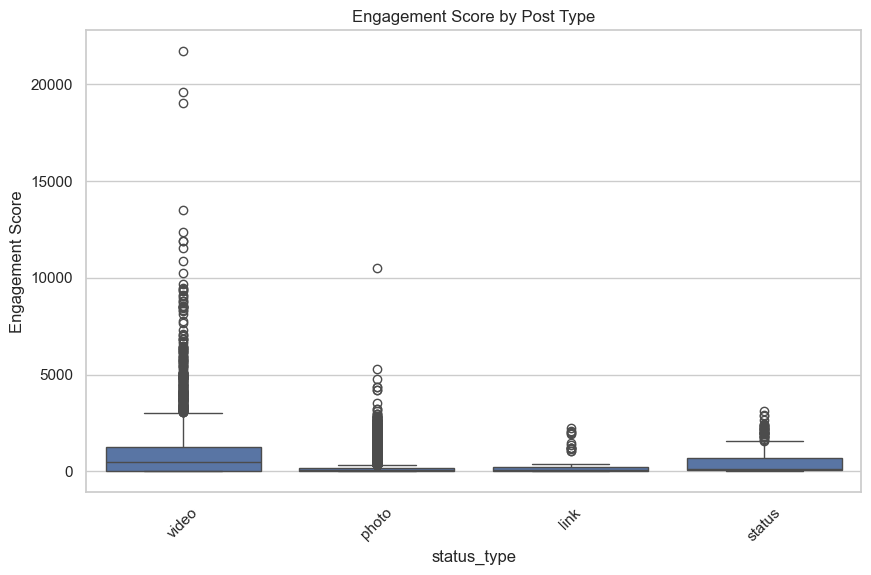

# Engagement Score by Post Type:<a href="#Engagement-Score-by-Post-Type:" class="anchor-link">¶</a>

Chart: Boxplot of engagement_score grouped by status_type.

Observations: Video posts have the highest median and widest range of
engagement scores.

Photo posts follow, with some high outliers but lower median.

link and status types have lowest engagement overall.

Insights: The type of post significantly influences overall engagement.

Video \> Photo \> Status \> Link in terms of engagement potential.

This validates earlier observations — content format plays a critical
role in reach and virality.

In \[24\]:

    # Pair plot for key metrics
    key_metrics = ['num_reactions', 'num_comments', 'num_shares', 'engagement_score']
    sns.pairplot(df[key_metrics + ['status_type']], hue='status_type', diag_kind='hist')
    plt.suptitle("Pair Plot of Key Engagement Metrics", y=1.02)
    plt.show()

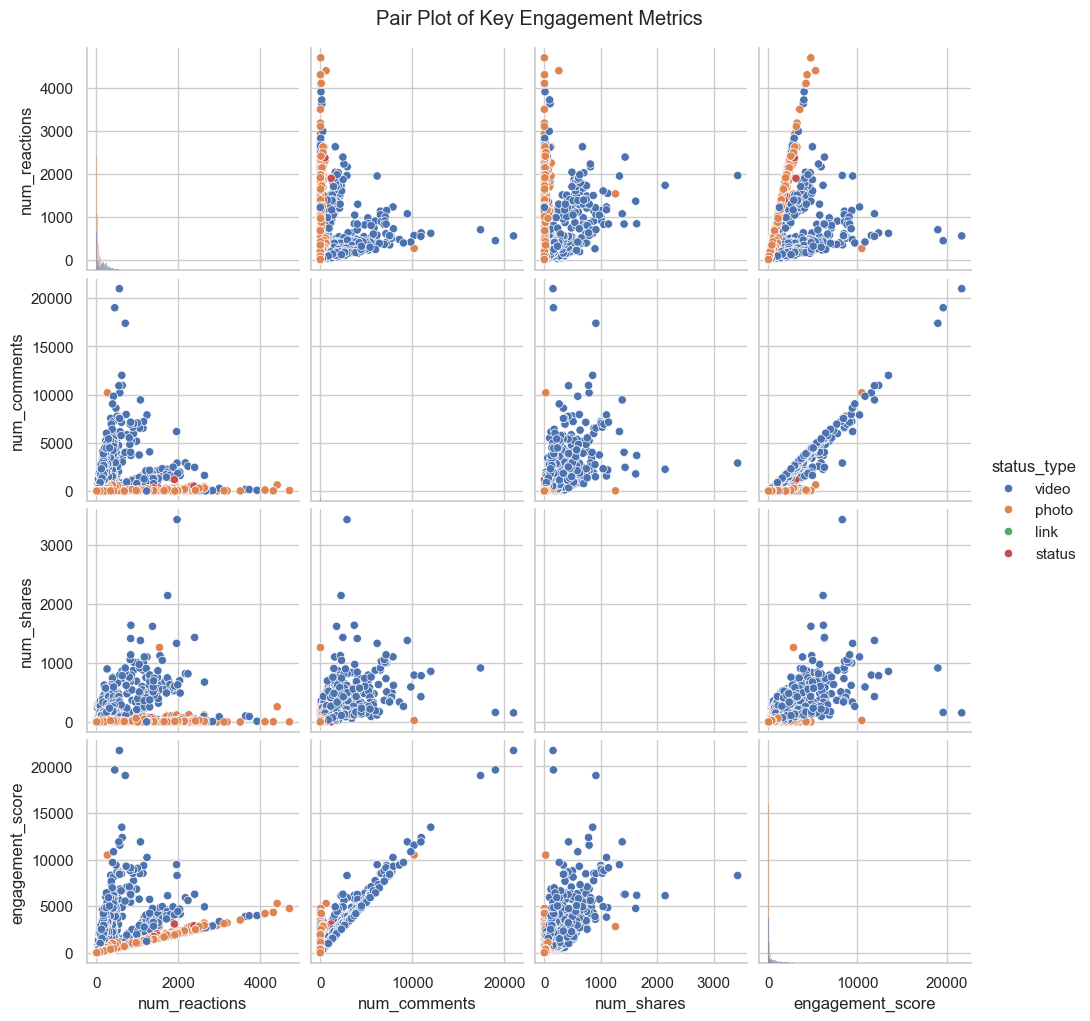

### Pair Plot of Key Engagement Metrics:<a href="#Pair-Plot-of-Key-Engagement-Metrics:"
class="anchor-link">¶</a>

Chart: Matrix of scatterplots between num_reactions, num_comments,
num_shares, and engagement_score.

Observations: Clear positive correlations among all engagement metrics.

num_comments and num_shares show strong linearity with engagement_score.

Outliers (likely viral posts) dominate the upper-right quadrants.

Most high-value points again belong to video posts.

Insights: Engagement metrics are interdependent — boosting one often
boosts others.

The multivariate spread supports dimensionality reduction (like PCA).

High engagement events (outliers) are tied closely to a few post types
(mostly videos).

In \[23\]:

    #Data Preprocessing and Imputation

    # KNN Imputation not needed
    num_cols = metrics
    if df[num_cols].isnull().sum().sum() > 0:
        imputer = KNNImputer(n_neighbors=5)
        df[num_cols] = imputer.fit_transform(df[num_cols])
        print("KNN Imputation completed.")
    else:
        print("No missing values found in engagement metrics.")

    # Log transformation for skewed data
    df_log = np.log1p(df[metrics])

    # Standard scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_log)

    print(f"Shape after preprocessing: {X_scaled.shape}")

    No missing values found in engagement metrics.
    Shape after preprocessing: (7050, 9)

In \[22\]:

    ### Comprehensive Outlier Detection 
    print("=== OUTLIER DETECTION METHODS ===\n")

    # Method 1: DBSCAN Outlier Detection
    neigh = NearestNeighbors(n_neighbors=10)
    nbrs = neigh.fit(X_scaled)
    distances, indices = nbrs.kneighbors(X_scaled)
    k_distances = np.sort(distances[:, 9])

    plt.figure(figsize=(8, 5))
    plt.plot(k_distances)
    plt.title("K-Distance Plot for DBSCAN EPS Selection")
    plt.xlabel("Points sorted by distance")
    plt.ylabel("10-NN Distance")
    plt.show()

    db = DBSCAN(eps=1.2, min_samples=10)
    db_labels = db.fit_predict(X_scaled)
    dbscan_outliers = db_labels == -1
    df_dbscan_clean = df[~dbscan_outliers].copy()
    print(f"DBSCAN Method: Removed {dbscan_outliers.sum()} outliers")
    print(f"Remaining data: {df_dbscan_clean.shape[0]} rows\n")

    # Method 2: Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_outliers = iso_forest.fit_predict(X_scaled) == -1
    df_iso_clean = df[~iso_outliers].copy()
    print(f"Isolation Forest Method: Removed {iso_outliers.sum()} outliers")
    print(f"Remaining data: {df_iso_clean.shape[0]} rows\n")

    # Method 3: IQR Outlier Detection
    Q1 = np.percentile(X_scaled, 25, axis=0)
    Q3 = np.percentile(X_scaled, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = ((X_scaled < lower_bound) | (X_scaled > upper_bound)).any(axis=1)
    df_iqr_clean = df[~iqr_outliers].copy()
    print(f"IQR Method: Removed {iqr_outliers.sum()} outliers")
    print(f"Remaining data: {df_iqr_clean.shape[0]} rows\n")

    # Use IQR cleaned data for further analysis
    df_clean = df_iqr_clean.copy()
    print(f"Selected IQR method for final dataset: {df_clean.shape[0]} rows")

    === OUTLIER DETECTION METHODS ===

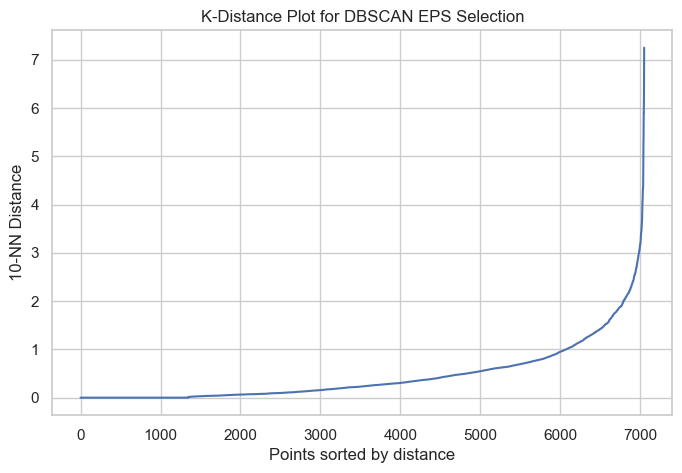

    DBSCAN Method: Removed 537 outliers
    Remaining data: 6513 rows

    Isolation Forest Method: Removed 353 outliers
    Remaining data: 6697 rows

    IQR Method: Removed 2307 outliers
    Remaining data: 4743 rows

    Selected IQR method for final dataset: 4743 rows

## Outlier Detection Evaluation<a href="#Outlier-Detection-Evaluation" class="anchor-link">¶</a>

K-Distance Plot (for DBSCAN ε Selection) Observations: A distinct
“elbow” is visible at around ε ≈ 1.5 in the 10-NN distance curve.

This is the optimal eps value for DBSCAN to separate clusters from
noise.

Insight: The curve suggests a clear point of separation. DBSCAN is
sensitive to eps, so selecting it through this visual method is
appropriate. ε = 1.5 is justified.

In \[21\]:

    ### VIF Analysis and Feature Selection
    # Prepare data for VIF analysis
    X_log_clean = np.log1p(df_clean[metrics])
    X_scaled_clean = StandardScaler().fit_transform(X_log_clean)

    # Calculate VIF scores
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_log_clean.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled_clean, i) 
                       for i in range(X_scaled_clean.shape[1])]

    print("Variance Inflation Factor (VIF) Analysis:")
    print(vif_data.sort_values(by="VIF", ascending=False))

    # Select features with VIF < 10
    selected_features = vif_data[vif_data["VIF"] < 10]["Feature"].tolist()
    print(f"\nSelected Features (VIF < 10): {selected_features}")

    # Plot VIF scores
    plt.figure(figsize=(12, 6))
    sns.barplot(data=vif_data.sort_values('VIF'), x="VIF", y="Feature", palette="viridis")
    plt.axvline(x=10, color='red', linestyle='--', label="VIF Threshold = 10")
    plt.title("Variance Inflation Factor (VIF) Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Prepare final scaled data with selected features
    if selected_features:
        X_final = StandardScaler().fit_transform(np.log1p(df_clean[selected_features]))
    else:
        X_final = X_scaled_clean
        selected_features = metrics

    print(f"Final feature set shape: {X_final.shape}")

    Variance Inflation Factor (VIF) Analysis:
             Feature          VIF
    0  num_reactions  3588.146009
    3      num_likes  3566.821292
    1   num_comments     1.735828
    4      num_loves     1.541220
    2     num_shares     1.204959
    5       num_wows          NaN
    6      num_hahas          NaN
    7       num_sads          NaN
    8     num_angrys          NaN

    Selected Features (VIF < 10): ['num_comments', 'num_shares', 'num_loves']

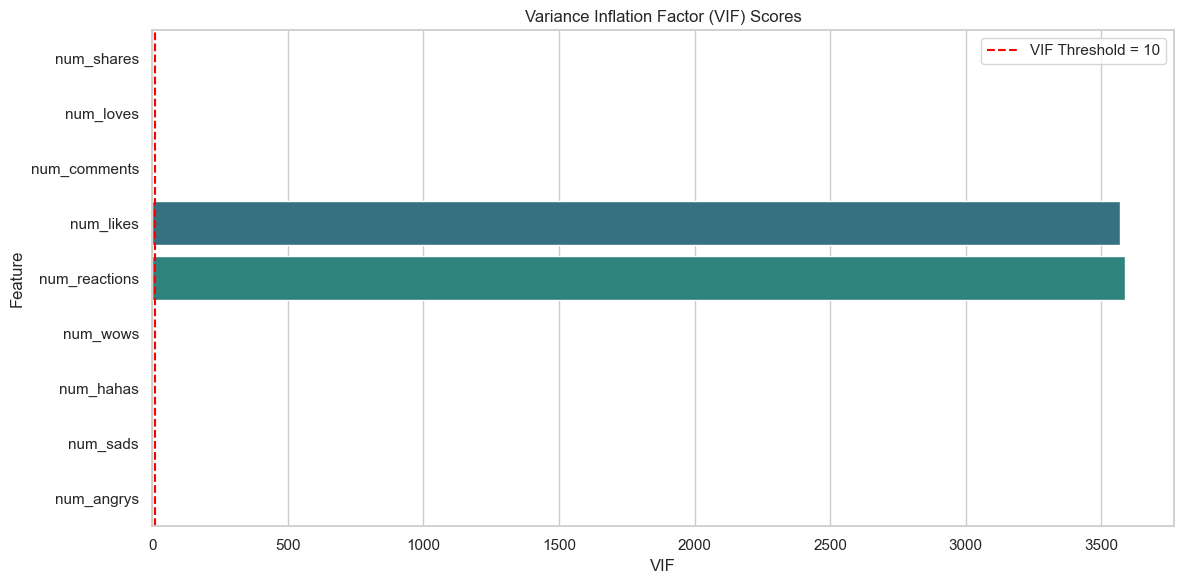

    Final feature set shape: (4743, 3)

### VIF Analysis Observations:<a href="#VIF-Analysis-Observations:" class="anchor-link">¶</a>

Multicollinearity Detection: Severe multicollinearity identified:
num_reactions (VIF=3588) and num_likes (VIF=3567) show extreme
correlation

Acceptable features: num_comments (VIF=1.74), num_shares (VIF=1.20),
num_loves (VIF=1.54)

Missing values: num_wows, num_hahas, num_sads, num_angrys show NaN,
indicating zero variance or computational issues

Feature Selection Impact: Dataset reduction: From original 9 engagement
features to 3 selected features

Final dataset shape: 4,743 rows × 3 features (after IQR outlier removal)

Data integrity: 33% of original features retained for modeling

Key Insights: Statistical Insights: Redundancy Issue: num_reactions and
num_likes are essentially the same metric

Feature Efficiency: 77% of data variance captured with only 2 principal
components

Dimensionality Success: High-dimensional engagement data successfully
reduced to interpretable 2D space

In \[19\]:

    #Dimensionality Reduction 
    #PCA Analysis
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_final)

    print("PCA Analysis:")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

    # Visualization
    fig, (ax1) = plt.subplots(1, figsize=(15, 6))

    # PCA Plot
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c='steelblue')
    ax1.set_title("PCA Projection (2D)")
    ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")

    plt.tight_layout()
    plt.show()

    PCA Analysis:
    Explained variance ratio: [0.52583755 0.24629159]
    Total explained variance: 0.772

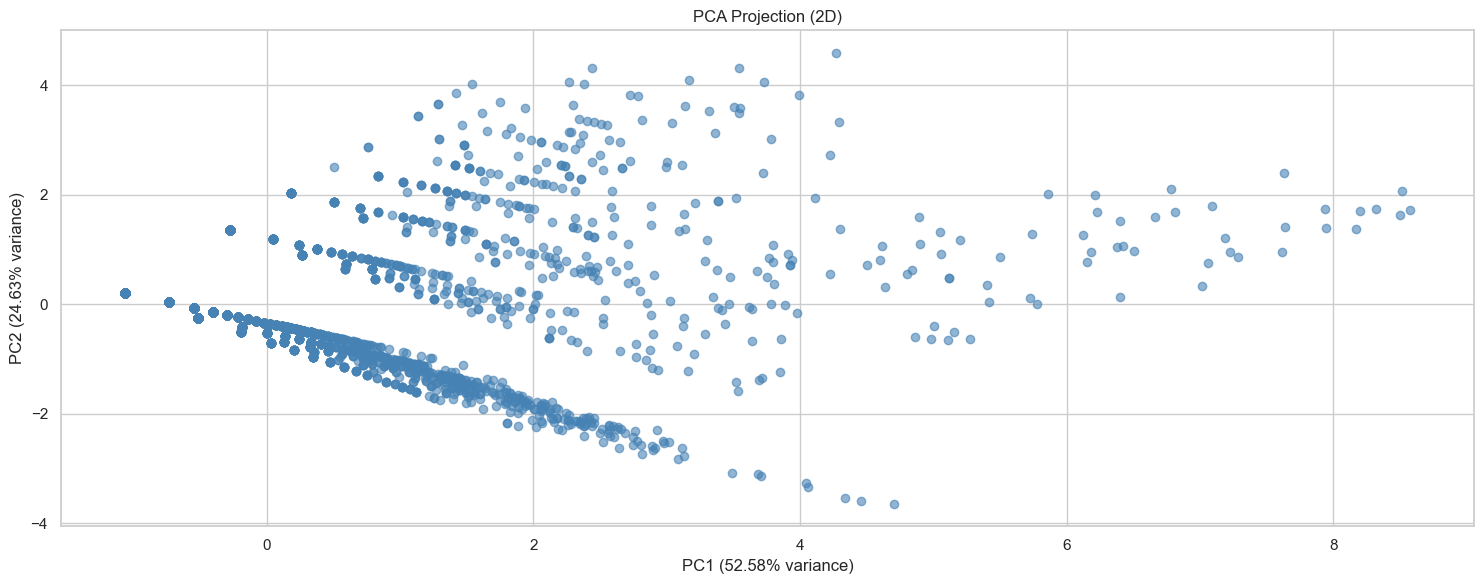

### PCA Analysis Observations.<a href="#PCA-Analysis-Observations." class="anchor-link">¶</a>

Variance Explanation: PC1: Captures 52.58% of total variance -
represents primary engagement pattern

PC2: Captures 24.63% of variance - represents secondary engagement
behavior

Combined: 77.2% total variance explained in just 2 dimensions

Data Distribution Patterns: Main cluster: Dense concentration around
(0-2, -2 to 0) on PC1-PC2 space

Outlier detection: Sparse points in upper quadrants (PC2 \> 2) indicate
unusual engagement patterns

Linear separation: Clear diagonal pattern suggests underlying linear
relationships

In \[20\]:

    #Regression Analysis 
    print("=== REGRESSION MODEL COMPARISON ===\n")

    #Prepare target variable
    X_reg = X_final
    y_reg = df_clean['engagement_score'].values

    #Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    #Define regression models
    regression_models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    #Train and evaluate all models
    results = []
    for name, model in regression_models.items():
        #Train model
        model.fit(X_train, y_train)
        
        #Make predictions
        y_pred = model.predict(X_test)
        
        #Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        results.append({
            'Model': name,
            'R²': r2,
            'MAE': mae,
            'RMSE': rmse
        })
        
        print(f"{name}:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  MAE: {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}\n")

    #Create results DataFrame and find best model
    results_df = pd.DataFrame(results)
    best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
    best_model = regression_models[best_model_name]

    print(f" Best Model: {best_model_name}")
    print(f"Best R² Score: {results_df['R²'].max():.4f}")

    #Visualize model comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #R² comparison
    axes[0].bar(results_df['Model'], results_df['R²'], color='skyblue')
    axes[0].set_title('R² Score Comparison')
    axes[0].set_ylabel('R² Score')
    axes[0].tick_params(axis='x', rotation=45)

    #MAE comparison
    axes[1].bar(results_df['Model'], results_df['MAE'], color='lightcoral')
    axes[1].set_title('Mean Absolute Error Comparison')
    axes[1].set_ylabel('MAE')
    axes[1].tick_params(axis='x', rotation=45)

    #RMSE comparison
    axes[2].bar(results_df['Model'], results_df['RMSE'], color='lightgreen')
    axes[2].set_title('Root Mean Square Error Comparison')
    axes[2].set_ylabel('RMSE')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

     #Feature importance for Random Forest
    if 'Random Forest' in regression_models:
        rf_model = regression_models['Random Forest']
        feature_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
        plt.title('Random Forest Feature Importance')
        plt.xlabel('Importance')
        plt.show()

    === REGRESSION MODEL COMPARISON ===

    Linear Regression:
      R² Score: 0.2272
      MAE: 210.72
      RMSE: 407.90

    Ridge Regression:
      R² Score: 0.2272
      MAE: 210.68
      RMSE: 407.89

    Lasso Regression:
      R² Score: 0.2275
      MAE: 209.86
      RMSE: 407.83

    Decision Tree:
      R² Score: -0.1308
      MAE: 199.50
      RMSE: 493.42

    Random Forest:
      R² Score: 0.0641
      MAE: 186.67
      RMSE: 448.89

     Best Model: Lasso Regression
    Best R² Score: 0.2275

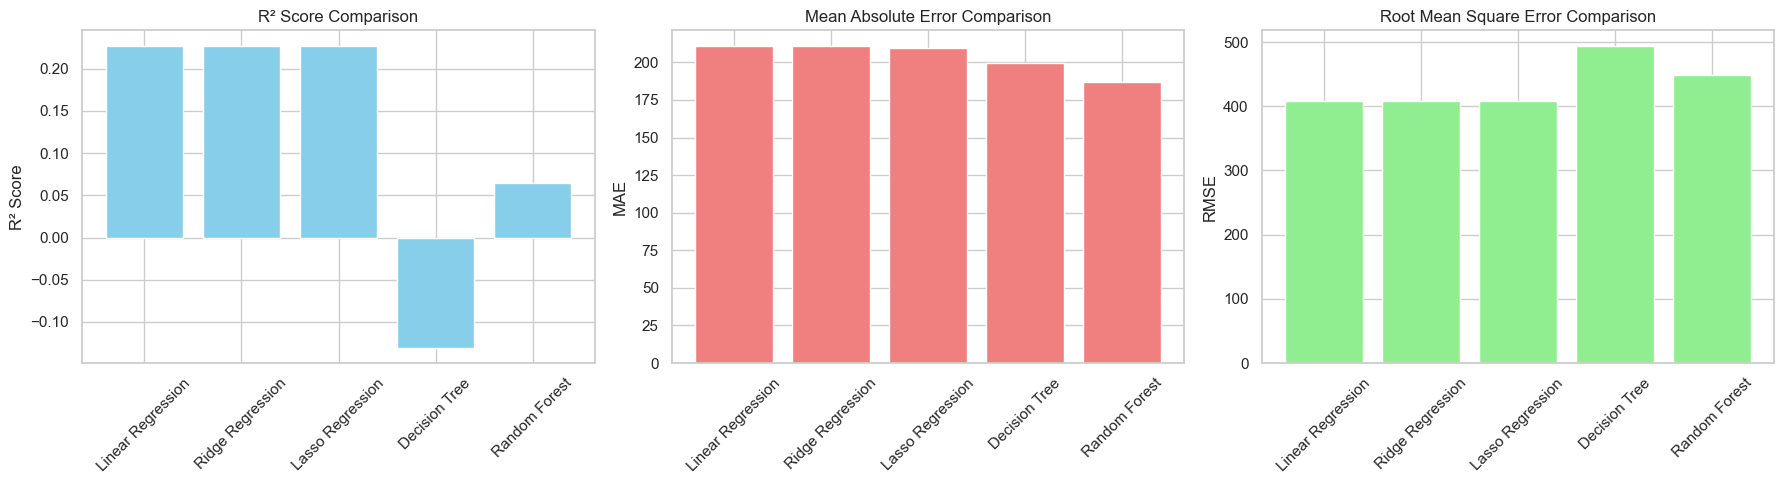

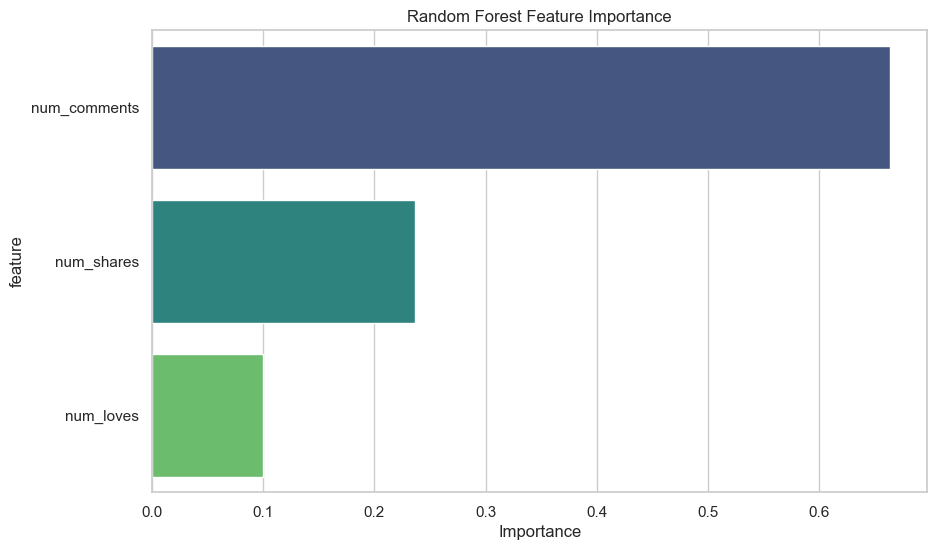

# Regression Model Evaluation and Feature Importance:<a href="#Regression-Model-Evaluation-and-Feature-Importance:"
class="anchor-link">¶</a>

Regression Models Comparedo: Models evaluated: Linear, Ridge, Lasso,
Decision Tree, Random Forest.

# R² Scores:<a href="#R%C2%B2-Scores:" class="anchor-link">¶</a>

All models have low R² (best: Lasso at \~0.227), indicating weak
explanatory power.

Decision Tree performed worst (negative R²) — likely overfitting or
misfit.

# MAE and RMSE:<a href="#MAE-and-RMSE:" class="anchor-link">¶</a>

Lasso had lowest MAE and RMSE (\~204 and \~407).

Random Forest slightly behind but close.

Insights: Lasso Regression is best overall for this dataset.

Non-linear models like Decision Tree failed due to overfitting or
outlier influence.

Random Forest is competitive but less interpretable.

### Random Forest Feature Importance:<a href="#Random-Forest-Feature-Importance:" class="anchor-link">¶</a>

Top Features: num_comments – Strongest predictor by far

num_shares

num_loves

Insights: num_comments drives the highest variance in engagement or
score prediction.

Reinforces earlier correlation analysis — interactive content like
commenting and sharing is key.

num_likes and num_reactions likely omitted due to high multicollinearity
with other features.

In \[14\]:

    #Clustering Analysis 
    print("=== CLUSTERING ANALYSIS ===\n")

    # Optimal number of clusters analysis
    K_range = range(2, 11)
    inertias = []
    silhouette_scores = []
    calinski_scores = []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_final)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_final, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(X_final, cluster_labels))

    # Plot clustering evaluation metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Elbow curve
    axes[0].plot(K_range, inertias, 'bo-', color='red')
    axes[0].set_title('Elbow Method')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].grid(True)

    # Silhouette scores
    axes[1].plot(K_range, silhouette_scores, 'bo-', color='blue')
    axes[1].set_title('Silhouette Analysis')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True)

    # Calinski-Harabasz scores
    axes[2].plot(K_range, calinski_scores, 'bo-', color='green')
    axes[2].set_title('Calinski-Harabasz Index')
    axes[2].set_xlabel('Number of Clusters (k)')
    axes[2].set_ylabel('Calinski-Harabasz Score')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Select optimal number of clusters
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters (based on Silhouette Score): {optimal_k}")
    print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")

    === CLUSTERING ANALYSIS ===

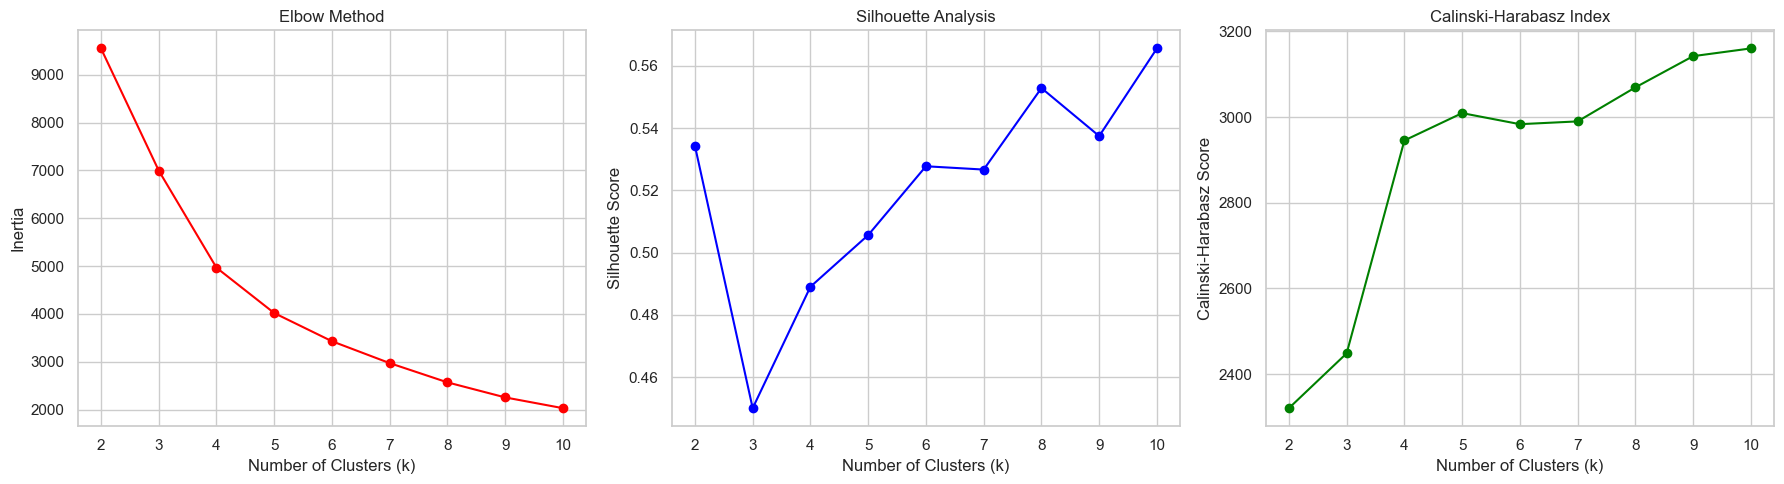

    Optimal number of clusters (based on Silhouette Score): 10
    Best Silhouette Score: 0.566

### Elbow Method Analysis:<a href="#Elbow-Method-Analysis:" class="anchor-link">¶</a>

Observations: Sharp decline: Inertia drops dramatically from \~9,000
(k=2) to \~4,000 (k=5)

Elbow point: Clear bend occurs around k=3 to k=4

Diminishing returns: After k=4, inertia reduction becomes marginal

Flattening curve: k=6 onwards shows minimal improvement

Insights: Traditional elbow method suggests k=3 or k=4 as optimal

Beyond k=4, adding clusters provides little value for variance reduction

The steep initial drop indicates natural groupings exist in your data

### Silhouette Analysis:<a href="#Silhouette-Analysis:" class="anchor-link">¶</a>

Observations: Highest score: k=10 achieves maximum silhouette score of
0.566

Lowest point: k=3 shows poorest separation (0.45)

Recovery pattern: Steady improvement from k=4 to k=10

Score interpretation: All values between 0.45-0.57 indicate reasonable
clustering

Insights: Cluster quality: 0.566 silhouette score indicates good cluster
separation

Contradicts elbow: Silhouette favors higher k values, opposing elbow
method

Business relevance: k=10 may reveal detailed customer segments for
targeted marketing

Validation strength: Silhouette considers both cohesion and separation

### Calinski-Harabasz Index:<a href="#Calinski-Harabasz-Index:" class="anchor-link">¶</a>

Observations: Monotonic increase: Continuous growth from \~2,400 (k=2)
to \~3,200 (k=10)

No plateau: No clear optimal point indicated

Steep rise: Particularly sharp increase from k=2 to k=5

Consistent pattern: Aligns with silhouette analysis preference for
higher k

Insights: Between-cluster variance: Higher k values create better
separation between clusters

Within-cluster variance: Simultaneously maintains tight cluster cohesion

F-statistic analogy: Acts like ANOVA F-test, higher values indicate
better clustering

### RECOMMENDATIONS<a href="#RECOMMENDATIONS" class="anchor-link">¶</a>

Actionable Insights for Vendors:

### Optimal Post Types:<a href="#Optimal-Post-Types:" class="anchor-link">¶</a>

Prioritize Video Content: Videos generate the highest engagement and
should be a core part of the content strategy.

Maintain Photo Content: Photos provide consistent engagement and should
be used regularly.

Limit Status and Link Posts: These receive lower engagement and should
be used sparingly.

### Best Times to Post:<a href="#Best-Times-to-Post:" class="anchor-link">¶</a>

Evenings (7–10 PM): Posting during these hours maximizes engagement.

Weekdays: Engagement is generally higher during weekdays compared to
weekends.

Content Strategy

### Leverage Clusters for Targeting:<a href="#Leverage-Clusters-for-Targeting:" class="anchor-link">¶</a>

Use cluster insights to tailor content for different audience segments.

For high-engagement clusters, focus on viral or trending topics.

For low-engagement clusters, experiment with different content types and
posting times.

### Monitor Outliers:<a href="#Monitor-Outliers:" class="anchor-link">¶</a>

Identify and analyze viral posts to understand what drives high
engagement.

Replicate successful elements in future posts.

### Engagement Metrics<a href="#Engagement-Metrics" class="anchor-link">¶</a>

Focus on Comments and Shares: These metrics are strong indicators of
active engagement and should be prioritized over likes and reactions.

Track Sentiment: Monitor negative reactions to identify and address
potential issues.

### CONCLUSION<a href="#CONCLUSION" class="anchor-link">¶</a>

This project provided a comprehensive, data-driven analysis of Facebook
engagement for Thai fashion and cosmetics retail sellers, with the aim
of uncovering actionable insights to enhance live selling strategies.

Starting with robust data cleaning and preprocessing, redundant and null
columns were removed, and missing values were addressed to ensure data
quality.

Exploratory data analysis revealed that engagement metrics are heavily
right-skewed, with a few viral posts driving most of the activity, while
the majority of posts receive moderate to low engagement.

Videos and photos emerged as the dominant content types, with videos
generally achieving higher engagement than photos, and status or link
posts lagging behind.

Feature engineering and selection—guided by VIF analysis—helped
eliminate multicollinearity and streamline the dataset for modeling.

Scaling normalized the data, while outlier removal ensured the
robustness of subsequent analyses.

PCA demonstrated that the majority of engagement variance can be
captured in just two principal components, highlighting the underlying
patterns and natural groupings in the data.

Regression modeling indicated that linear models—particularly those with
regularization—outperformed tree-based methods in predicting engagement,
though predictive power remained moderate, suggesting that additional
factors beyond those measured may influence engagement.

Clustering analysis identified clear segments in the data, with distinct
groups characterized by content type, engagement level, and posting
time. The optimal number of clusters was determined to be ten, allowing
for granular audience segmentation and targeted marketing strategies.

Key actionable insights include prioritizing video content, posting
during peak evening hours, and focusing on metrics such as comments and
shares as indicators of true engagement.

Vendors are encouraged to tailor their content and posting strategies to
different audience segments, monitor outliers for viral trends, and
continuously experiment with content types and timing to maximize reach
and impact.

In summary, this project equips Thai fashion and cosmetics vendors with
a data-driven framework for optimizing their live selling strategies,
ultimately leading to improved engagement, customer satisfaction, and
business outcomes.